***Ricardo Madrigal Urencio***

In [ ]:
! pip install pymongo
! pip install -U plotly
! pip install squarify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 51.9 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [ ]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import ipywidgets as widgets
from IPython.display import display, clear_output

import plotly.io as pio
pio.renderers.default = "notebook_connected"  # opción segura en Colab

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

%matplotlib inline

In [ ]:
# Datos de conexión
usuario = "madris1402"
password = "maranes8"
cluster = "clusterrmu.s1ici9p.mongodb.net"
base_datos = "analytics"
coleccion = "sales_cubo"

# Cadena de conexión
uri = f"mongodb+srv://{usuario}:{password}@{cluster}/?retryWrites=true&w=majority"
# Crear cliente
client = MongoClient(uri)

#Madrigal Urencio Ricardo
client

#Conexion a la DB
db = client[base_datos]
coll = db[coleccion]

print(db)
print(coll)

Database(MongoClient(host=['ac-tljpgji-shard-00-00.s1ici9p.mongodb.net:27017', 'ac-tljpgji-shard-00-02.s1ici9p.mongodb.net:27017', 'ac-tljpgji-shard-00-01.s1ici9p.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='atlas-10ra0l-shard-0', tls=True), 'analytics')
Collection(Database(MongoClient(host=['ac-tljpgji-shard-00-00.s1ici9p.mongodb.net:27017', 'ac-tljpgji-shard-00-02.s1ici9p.mongodb.net:27017', 'ac-tljpgji-shard-00-01.s1ici9p.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='atlas-10ra0l-shard-0', tls=True), 'analytics'), 'sales_cubo')


###**Consulta 1 – SLICE:**
- Promedio de edad de los clientes por país y género, considerando únicamente la categoría Technology.
- Visualiza con un gráfico de barras agrupadas.

In [ ]:
#Ricardo Madrigal Urencio
pipeline = [
    {
        "$match": {
            "category": "Technology"
        }
    },
    {
        "$group": {
            "_id": {
                "pais": "$country_name",
                "genero": "$gender"
            },
            "avg_edad": {
                "$avg": "$age"
            }
        }
    },
    {
        "$project": {
            "_id": 0,
            "pais": "$_id.pais",
            "genero": "$_id.genero",
            "avg_edad": {"$floor": ["$avg_edad"]}
        }
    },
    {"$sort": {"pais": 1, "genero": 1}}
]

result = list(coll.aggregate(pipeline))

df = pd.json_normalize(result)

df

,pais,genero,avg_edad
0,Argentina,Female,46.0
1,Argentina,Male,64.0
2,Argentina,Non-Binary,49.0
3,Australia,Female,51.0
4,Australia,Male,41.0
...,...,...,...
85,United States,Male,24.0
86,United States,Non-Binary,48.0
87,Venezuela,Female,49.0
88,Venezuela,Male,51.0


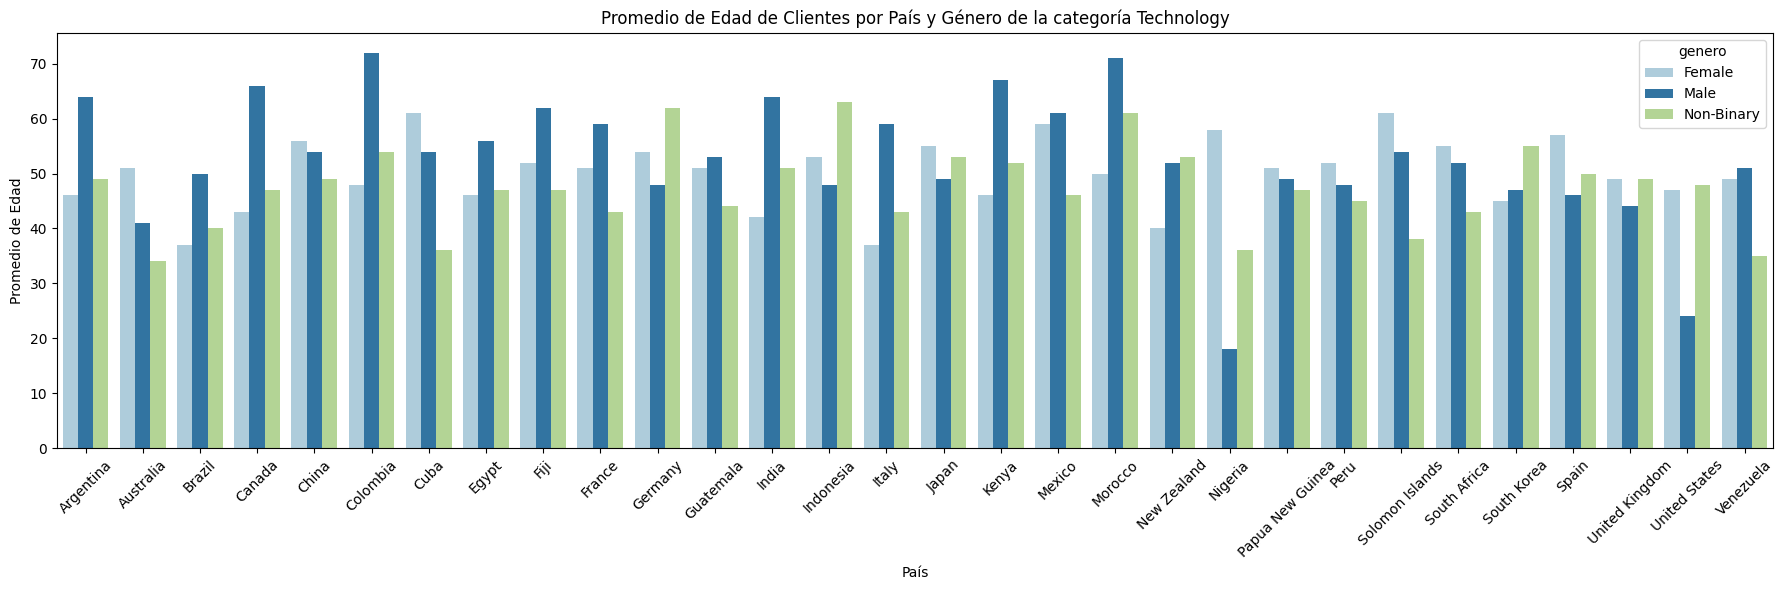

In [ ]:
#Grafica de Barras
plt.figure(figsize=(18, 6))
sns.barplot(x='pais', y='avg_edad', hue='genero', data=df, palette='Paired')
plt.title('Promedio de Edad de Clientes por País y Género de la categoría Technology')
plt.xticks(rotation=45)
plt.xlabel('País')
plt.ylabel('Promedio de Edad')
plt.tight_layout()
plt.show()

###**Consulta 2 – DICE:**
- Promedio de edad de los clientes filtrando múltiples dimensiones: categoría Technology, que no sean en fin de semana y años entre 2020 y 2022.
- Usa un gráfico interactivo o comparativo.

In [ ]:
#Ricardo Madrigal Urencio
pipeline = [
    {
        "$match": {
            "category": "Technology",
            "is_weekend": {"$ne": True},
            "year": {"$gte": 2020, "$lte": 2022}
            }
    },
    {
        "$group": {
            "_id": {"anio": "$year"},
            "avg_edad": {
                "$avg": "$age"
            }
        }
    },
    {
        "$project": {
            "_id": 0,
            "avg_edad": {"$floor": ["$avg_edad"]},
            "año": "$_id.anio"
        }
    }
]

result = list(coll.aggregate(pipeline))

df = pd.json_normalize(result)

df

,avg_edad,año
0,51.0,2020
1,51.0,2022
2,56.0,2021


In [ ]:
#Grafica comparativa
fig = px.treemap(
    df, values='avg_edad', path=['año'],
    title= "Promedio de edad de los clientes filtrando múltiples dimensiones: categoría Technology, que no sean en fin de semana y años entre 2020 y 2022",
    labels={'avg_edad': 'Promedio de Edad', 'año': 'Año'},
)

fig.update_traces(textinfo='label+value+percent entry')
fig.show()

###**Consulta 3 – ROLL-UP:**
- Total de unidades vendidas por continente.
- Utiliza un gráfico tipo pastel o barras.

In [ ]:
#Ricardo Madrigal Urencio
pipeline = [
    {
        "$group": {
            "_id": "$continent",
            "total_unidades": {
                "$sum": "$units_sold"
            }
        }
        },
    {
        "$project": {
            "_id": 0,
            "continente": "$_id",
            "total_unidades": 1
        }
    }
]

result = list(coll.aggregate(pipeline))

df = pd.json_normalize(result)

df

,total_unidades,continente
0,15850,Oceania
1,15085,Asia
2,17431,Europe
3,17568,South America
4,15258,North America
5,14938,Africa


In [ ]:
#Grafica de Pastel
fig = px.pie(df, values='total_unidades', names='continente', title='Total de unidades vendidas por continente',
             labels={'total_unidades': 'Total de Unidades Vendidas', 'continente': 'Continente'}
             )
fig.show()

###**Consulta 4 – Ranking de países por ganancia total:**
- Lista de clientes mayores de 75 años ordenados por total de descuento.
- Visualiza con un gráfico horizontal ordenado.

In [ ]:
#Ricardo Madrigal Urencio
pipeline = [
    {
        "$match": {
            "age": {"$gt": 75}
        }
    },
    {
        "$group": {
            "_id": {"cliente": "$customer", "edad": "$age"},
            "total_descuento": {
                "$sum": "$discount"
            },

        }
        },
    {
        "$project": {
            "_id": 0,
            "total_descuento": 1,
            "cliente_edad": {"$concat": ["$_id.cliente", " - ", {"$toString": "$_id.edad"}, " años"]}
        }
        },
    {
        "$sort": {
            "total_descuento": -1
        }
    }
]

result = list(coll.aggregate(pipeline))

df = pd.json_normalize(result)

df

,total_descuento,cliente_edad
0,1002.72,Tyler Reyes - 80 años
1,646.20,Brandon Evans - 76 años
2,605.42,Lisa Adams - 80 años
3,594.03,Danielle Johnson - 77 años
4,573.76,Brooke Leonard - 78 años
5,564.18,Allison Maddox - 77 años
6,466.76,Kevin Elliott - 79 años
7,461.67,Linda Wolfe - 77 años
8,453.02,Casey Elliott - 80 años
9,448.14,Kelli Conley - 80 años


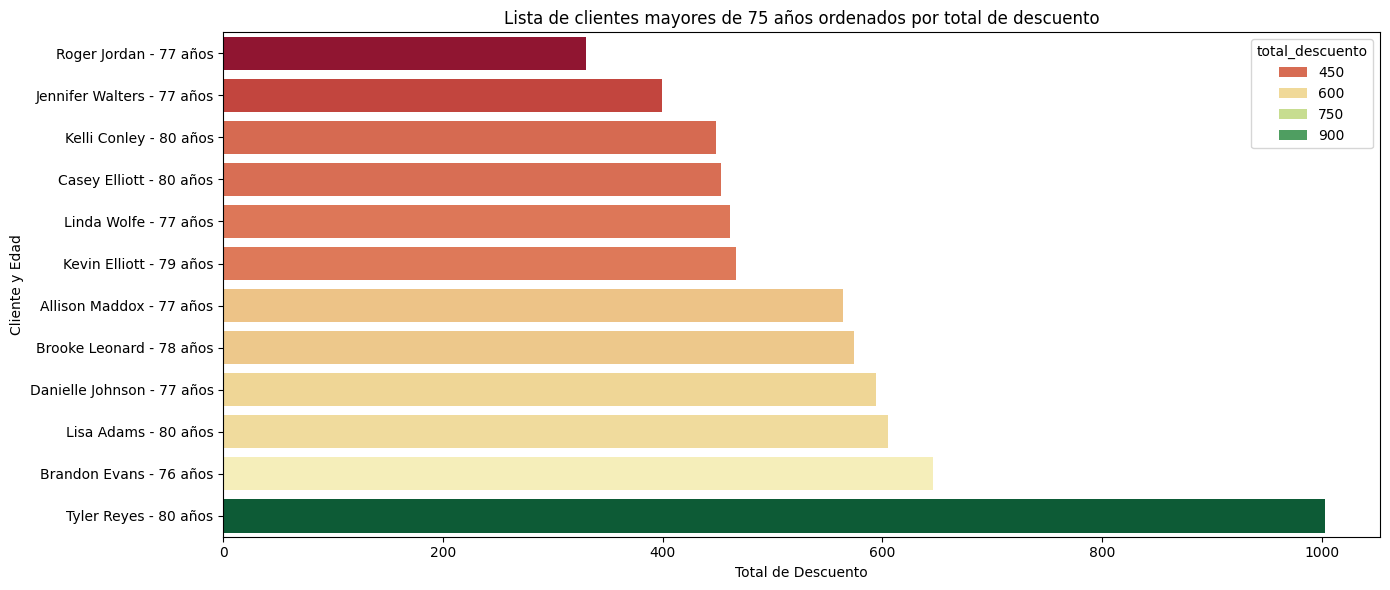

In [ ]:
#Grafico Horizontal Ordenado
plt.figure(figsize=(14, 6))
sns.barplot(x='total_descuento', y='cliente_edad', data=df, palette='RdYlGn', hue='total_descuento')
plt.xlabel('Total de Descuento')
plt.ylabel('Cliente y Edad')
plt.title('Lista de clientes mayores de 75 años ordenados por total de descuento')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### **Consulta 5 – DRILL-DOWN:**
- Top 3 clientes más rentables dentro de cada region, utilizando *\$push* y *\$slice*.
- Usa un gráfico agrupado por continente.

In [ ]:
#Ricardo Madrigal Urencio
pipeline = [
    {
        "$group": {
            "_id": {"continent": "$continent", "region": "$region", "cliente": "$customer"},
            "total_ganancia": {
                "$sum": "$profit"
            }
        }
    },
    {
        "$sort": {"_id.continent": 1, "_id.region": 1, "total_ganancia": -1}
    },
    {
        "$group": {
            "_id": {"continent": "$_id.continent", "region": "$_id.region"},
            "clientes": {
                "$push": {
                    "cliente": "$_id.cliente",
                    "ganancia": "$total_ganancia"
                }
            }
        }
    },
    {
        "$project": {
            "_id": 0,
            "continente": "$_id.continent",
            "region": "$_id.region",
            "top_clientes": {"$slice": ["$clientes", 3]}
        }
    },
    {"$sort": {"continente": 1, "region": 1}}
]

result = list(coll.aggregate(pipeline))

df = pd.json_normalize(result)

df_normalized = df.explode('top_clientes')
df_normalized = pd.json_normalize(df_normalized['top_clientes']).add_prefix('top_clientes.')
df = pd.concat([df['continente'], df['region'], df_normalized], axis=1)

df.dropna(inplace=True)

df

,continente,region,top_clientes.cliente,top_clientes.ganancia
0,Africa,Abuja,Valerie Kennedy,8798.1831
1,Africa,Alexandria,Linda Hudson,969.4200
2,Africa,Cairo,Kristin Lopez,550.3808
3,Africa,Casablanca,Marie Cross,3294.8259
4,Africa,Gauteng,Rebecca Brooks,1372.6308
...,...,...,...,...
85,South America,Medellin,Mark Simmons,261.8757
86,South America,Rio de Janeiro,Scott Lopez,168.9189
87,South America,Santa Fe,Kevin Elliott,7889.6877
88,South America,Sao Paulo,Gabriel Sanders,7567.5800


In [ ]:
#Grafico Agrupado por Continene
fig = px.bar(df, x='continente', y='top_clientes.ganancia', color='region',
             title='Top 3 Clientes más Rentables por Región y Continente',
             labels={'top_clientes.ganancia': 'Ganancia Total', 'region': 'Región', 'continente': 'Continente',
             'top_clientes.cliente': 'Cliente', 'top_clientes.ganancia': 'Ganancia Total'},
             barmode='group',
             hover_data=['top_clientes.cliente', 'top_clientes.ganancia'])

fig.update_layout(xaxis={'categoryorder':'total ascending'})

fig.show()